In [1]:
"""Trains a ResNet on the CIFAR10 dataset.

ResNet v1
[a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf

ResNet v2
[b] Identity Mappings in Deep Residual Networks
https://arxiv.org/pdf/1603.05027.pdf
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model
from keras.datasets import cifar10
from keras.utils import plot_model
from keras.utils import to_categorical
import numpy as np
import os

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
# epochs = 2
data_augmentation = True
num_classes = 10

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 12

# model version
# orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
print(model_type)

ResNet110v2


### Data preprocessing ( cifar10 )

In [3]:
# load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


### model build

In [4]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [5]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [6]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])

        num_filters_in = num_filters_out

    # add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [8]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

In [9]:
model.summary()
# plot_model(model, to_file="%s.png" % model_type, show_shapes=True)
print(model_type)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

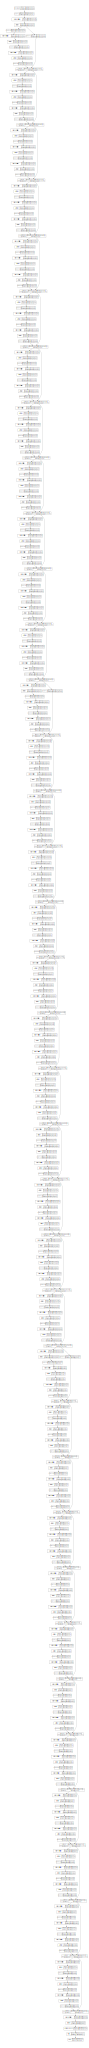

In [10]:
#  Display Model in Jupyter notebook

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_keras_model(model,show_shapes=True,show_layer_names=True):
    return SVG(model_to_dot(model,show_shapes=show_shapes,show_layer_names=show_layer_names).create(prog='dot',format='svg'))

plot_keras_model(model, show_shapes=True, show_layer_names=False)

### training

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

Learning rate:  0.001


In [14]:
# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_model')
# model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
model_name = 'cifar10_%s_model.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [15]:
epochs = 200

# run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # this will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        
        # set each sample mean to 0
        samplewise_center=False,
        
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        
        # divide each input by its std
        samplewise_std_normalization=False,
        
        # apply ZCA whitening
        zca_whitening=False,
        
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        
        # randomly shift images horizontally
        width_shift_range=0.1,
        
        # randomly shift images vertically
        height_shift_range=0.1,
        
        # randomly flip images
        horizontal_flip=True,
        
        # randomly flip images
        vertical_flip=False)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

Using real-time data augmentation.
Epoch 1/200
Learning rate:  0.001
1563/1563 [==============================] - 219s 140ms/step - loss: 1.4919 - acc: 0.6353 - val_loss: 2.0452 - val_acc: 0.5176

Epoch 00001: val_acc improved from -inf to 0.51760, saving model to /home/project/Advanced-Deep-Learning-With-Keras/chapter2-deep-networks/saved_model/cifar10_ResNet110v2_model.h5
Epoch 2/200
Learning rate:  0.001
1563/1563 [==============================] - 220s 141ms/step - loss: 1.2826 - acc: 0.6864 - val_loss: 1.3735 - val_acc: 0.6615

Epoch 00002: val_acc improved from 0.51760 to 0.66150, saving model to /home/project/Advanced-Deep-Learning-With-Keras/chapter2-deep-networks/saved_model/cifar10_ResNet110v2_model.h5
Epoch 3/200
Learning rate:  0.001
1563/1563 [==============================] - 219s 140ms/step - loss: 1.1612 - acc: 0.7207 - val_loss: 1.5516 - val_acc: 0.6049

Epoch 00003: val_acc did not improve from 0.66150
Epoch 4/200
Learning rate:  0.001
1563/1563 [=====================

1563/1563 [==============================] - 219s 140ms/step - loss: 0.5741 - acc: 0.8789 - val_loss: 0.8227 - val_acc: 0.8103

Epoch 00032: val_acc did not improve from 0.84790
Epoch 33/200
Learning rate:  0.001
1563/1563 [==============================] - 220s 141ms/step - loss: 0.5658 - acc: 0.8812 - val_loss: 0.7256 - val_acc: 0.8380

Epoch 00033: val_acc did not improve from 0.84790
Epoch 34/200
Learning rate:  0.001
1563/1563 [==============================] - 218s 139ms/step - loss: 0.5654 - acc: 0.8815 - val_loss: 0.6885 - val_acc: 0.8504

Epoch 00034: val_acc improved from 0.84790 to 0.85040, saving model to /home/project/Advanced-Deep-Learning-With-Keras/chapter2-deep-networks/saved_model/cifar10_ResNet110v2_model.h5
Epoch 35/200
Learning rate:  0.001
1563/1563 [==============================] - 218s 139ms/step - loss: 0.5631 - acc: 0.8823 - val_loss: 0.7590 - val_acc: 0.8361

Epoch 00035: val_acc did not improve from 0.85040
Epoch 36/200
Learning rate:  0.001
1563/1563 [====

1563/1563 [==============================] - 219s 140ms/step - loss: 0.4754 - acc: 0.9054 - val_loss: 0.5996 - val_acc: 0.8693

Epoch 00068: val_acc did not improve from 0.87290
Epoch 69/200
Learning rate:  0.001
1563/1563 [==============================] - 219s 140ms/step - loss: 0.4745 - acc: 0.9059 - val_loss: 0.7625 - val_acc: 0.8230

Epoch 00069: val_acc did not improve from 0.87290
Epoch 70/200
Learning rate:  0.001
1563/1563 [==============================] - 219s 140ms/step - loss: 0.4727 - acc: 0.9063 - val_loss: 0.8871 - val_acc: 0.8095

Epoch 00070: val_acc did not improve from 0.87290
Epoch 71/200
Learning rate:  0.001
1563/1563 [==============================] - 219s 140ms/step - loss: 0.4715 - acc: 0.9067 - val_loss: 0.8346 - val_acc: 0.8144

Epoch 00071: val_acc did not improve from 0.87290
Epoch 72/200
Learning rate:  0.001
1563/1563 [==============================] - 218s 140ms/step - loss: 0.4780 - acc: 0.9052 - val_loss: 0.6135 - val_acc: 0.8618

Epoch 00072: val_acc

1563/1563 [==============================] - 219s 140ms/step - loss: 0.2318 - acc: 0.9721 - val_loss: 0.4185 - val_acc: 0.9200

Epoch 00102: val_acc did not improve from 0.92520
Epoch 103/200
Learning rate:  0.0001
1563/1563 [==============================] - 219s 140ms/step - loss: 0.2285 - acc: 0.9727 - val_loss: 0.4180 - val_acc: 0.9231

Epoch 00103: val_acc did not improve from 0.92520
Epoch 104/200
Learning rate:  0.0001
1563/1563 [==============================] - 220s 141ms/step - loss: 0.2259 - acc: 0.9732 - val_loss: 0.4234 - val_acc: 0.9185

Epoch 00104: val_acc did not improve from 0.92520
Epoch 105/200
Learning rate:  0.0001
1563/1563 [==============================] - 219s 140ms/step - loss: 0.2221 - acc: 0.9743 - val_loss: 0.4132 - val_acc: 0.9215

Epoch 00105: val_acc did not improve from 0.92520
Epoch 106/200
Learning rate:  0.0001
1563/1563 [==============================] - 219s 140ms/step - loss: 0.2180 - acc: 0.9751 - val_loss: 0.4192 - val_acc: 0.9215

Epoch 00106:

1563/1563 [==============================] - 218s 140ms/step - loss: 0.1678 - acc: 0.9869 - val_loss: 0.4054 - val_acc: 0.9273

Epoch 00138: val_acc did not improve from 0.92740
Epoch 139/200
Learning rate:  1e-05
1563/1563 [==============================] - 218s 140ms/step - loss: 0.1673 - acc: 0.9870 - val_loss: 0.4068 - val_acc: 0.9265

Epoch 00139: val_acc did not improve from 0.92740
Epoch 140/200
Learning rate:  1e-05
1563/1563 [==============================] - 219s 140ms/step - loss: 0.1687 - acc: 0.9855 - val_loss: 0.4088 - val_acc: 0.9269

Epoch 00140: val_acc did not improve from 0.92740
Epoch 141/200
Learning rate:  1e-05
1563/1563 [==============================] - 218s 139ms/step - loss: 0.1682 - acc: 0.9860 - val_loss: 0.4059 - val_acc: 0.9283

Epoch 00141: val_acc improved from 0.92740 to 0.92830, saving model to /home/project/Advanced-Deep-Learning-With-Keras/chapter2-deep-networks/saved_model/cifar10_ResNet110v2_model.h5
Epoch 142/200
Learning rate:  1e-05
1563/1563 [

1563/1563 [==============================] - 218s 140ms/step - loss: 0.1594 - acc: 0.9886 - val_loss: 0.4083 - val_acc: 0.9259

Epoch 00176: val_acc did not improve from 0.92830
Epoch 177/200
Learning rate:  1e-06
1563/1563 [==============================] - 218s 139ms/step - loss: 0.1600 - acc: 0.9877 - val_loss: 0.4103 - val_acc: 0.9260

Epoch 00177: val_acc did not improve from 0.92830
Epoch 178/200
Learning rate:  1e-06
1563/1563 [==============================] - 219s 140ms/step - loss: 0.1592 - acc: 0.9887 - val_loss: 0.4087 - val_acc: 0.9268

Epoch 00178: val_acc did not improve from 0.92830
Epoch 179/200
Learning rate:  1e-06
1563/1563 [==============================] - 219s 140ms/step - loss: 0.1583 - acc: 0.9888 - val_loss: 0.4081 - val_acc: 0.9263

Epoch 00179: val_acc did not improve from 0.92830
Epoch 180/200
Learning rate:  1e-06
1563/1563 [==============================] - 218s 140ms/step - loss: 0.1577 - acc: 0.9892 - val_loss: 0.4089 - val_acc: 0.9264

Epoch 00180: val

In [16]:
# score trained model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 9s 913us/step
Test loss: 0.4089770480155945
Test accuracy: 0.9262
